In [6]:
import torch
import torch.utils.data

from functools import partial
from utils import *
import utils
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 15)

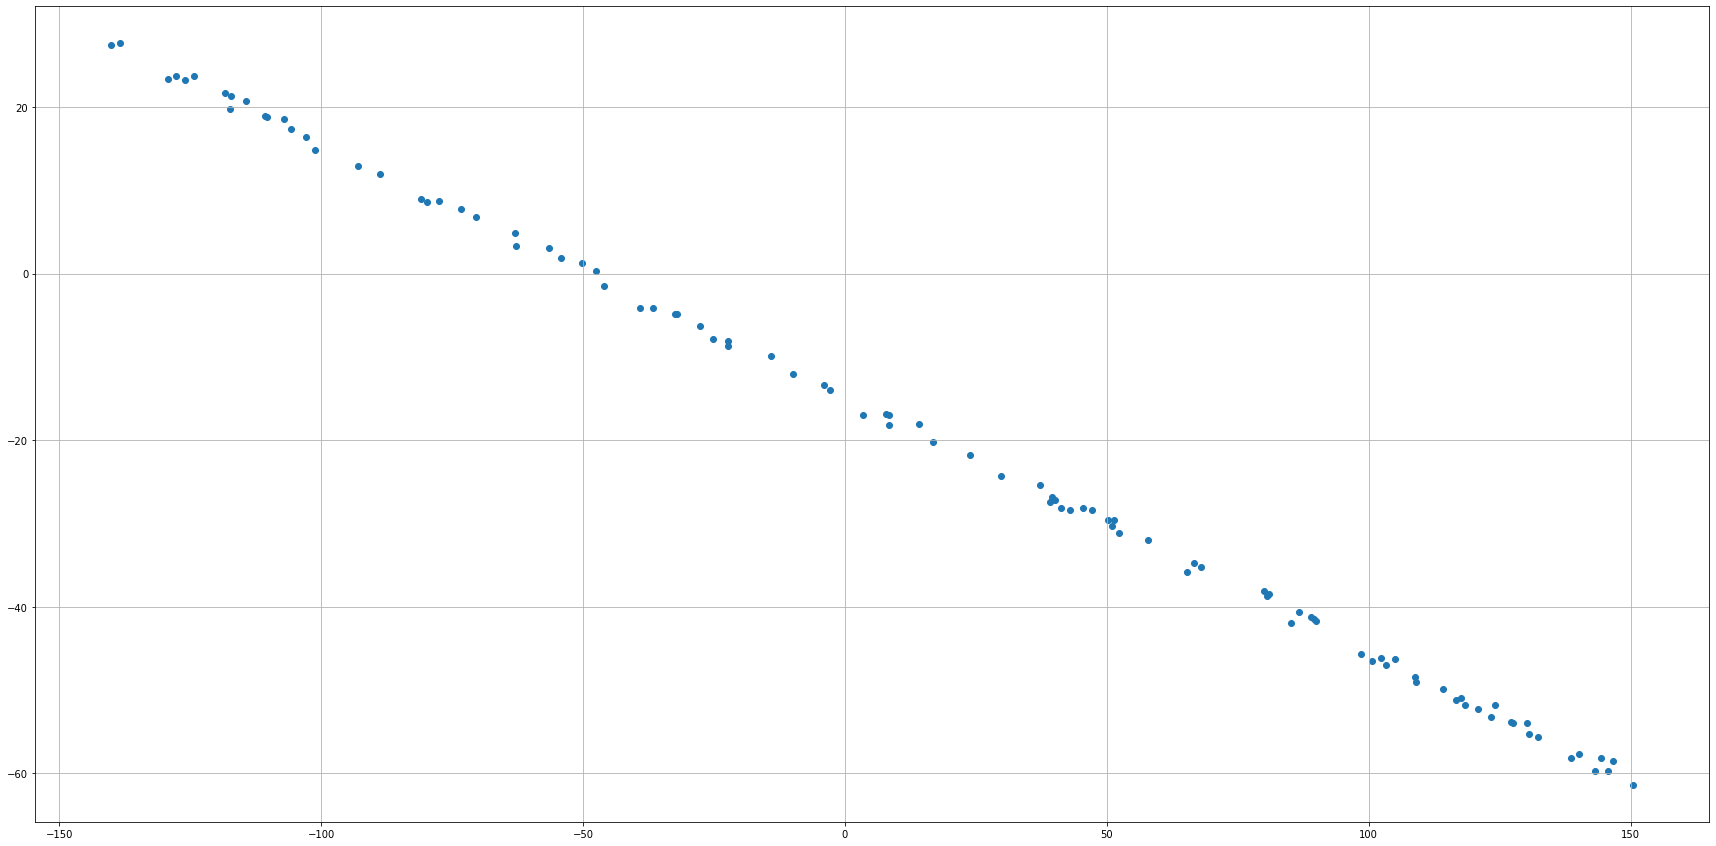

In [7]:
line = test_line(2, 100, 10, 20, 1)

ax = plt.figure().add_subplot()
ax.scatter(*line)
ax.grid(True)

In [10]:


def run_optim(xs, ys, optimizer_fr_model, model=torch.nn.Linear(1, 1), batch_size=1, epoch=1000):
    optimizer = optimizer_fr_model(model.parameters())
    delta = 1e-6

    xs = torch.tensor(xs, dtype=torch.float32)
    ys = torch.tensor(ys, dtype=torch.float32)
    points_xy = list(zip(xs, ys))

    loss = None
    prediction = None
    prev = 0
    cur = 1e9
    i = 0
    loader = torch.utils.data.DataLoader(points_xy, batch_size=batch_size, drop_last=False)
    it = iter(loader)
    while i < epoch and abs(prev - cur) > delta:
        batch = None
        try:
            batch = next(it)
        except StopIteration:
            it = iter(loader)
            batch = next(it)
        x, y = batch
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        i += 1
        optimizer.zero_grad()
        prediction = model(x)
        prediction = torch.reshape(prediction, (-1,))
        loss = torch.nn.functional.mse_loss(prediction, y)
        loss.backward()
        optimizer.step()
        prev = cur
        cur = loss.data
    prediction = model(xs)
    prediction = torch.reshape(prediction, (-1,))
    loss = torch.nn.functional.mse_loss(prediction, ys)
    return loss.data, [list(model.parameters())[0].data[0, 0].item(), list(model.parameters())[1].data[0].item()]

def compare(verbose_name, my_algo, my_config,  torch_algo, torch_config):
    loss_data, params = run_optim(*line, partial(torch_algo, **torch_config), torch.nn.Linear(1, 1), batch_size=1)
    print(f"loss_data_{verbose_name}", loss_data)
    draw_2d(*line, params[::-1], title=f"For {verbose_name}")
    regression(*line, method=my_algo, **my_config)
    print("-"*50)

loss_data_ada_grad tensor(1.0233)
came close by 10.216983717203275
--------------------------------------------------
loss_data_rms_prop tensor(5.1740)
came close by 53.345478271445934
--------------------------------------------------
loss_data_rms_prop tensor(0.4779)
came close by 11.924212523405721
--------------------------------------------------


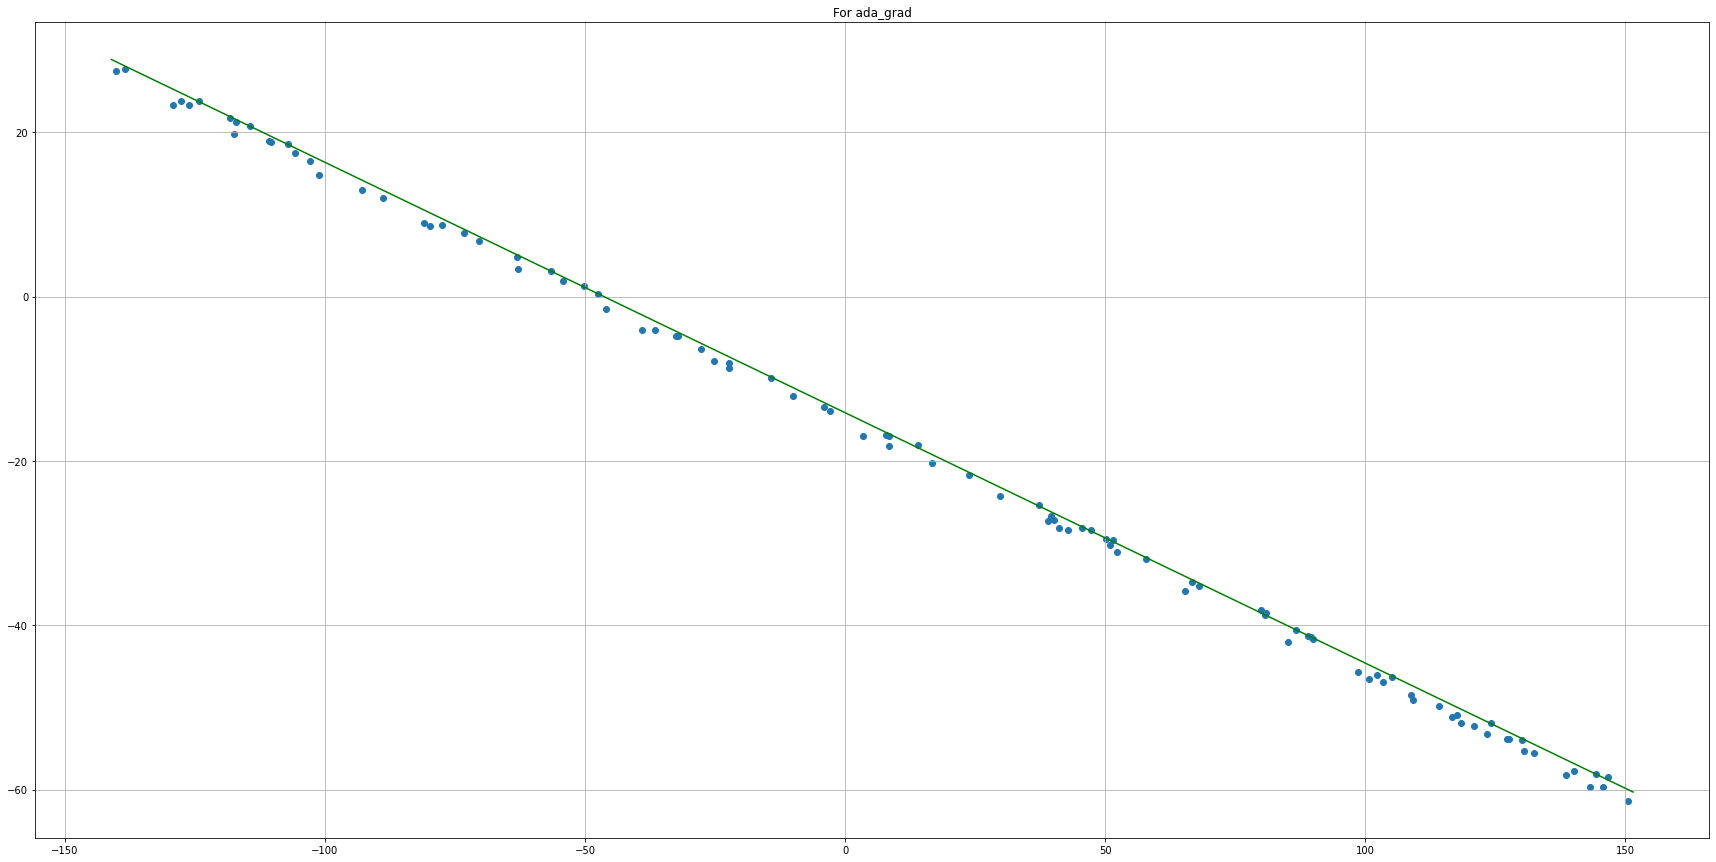

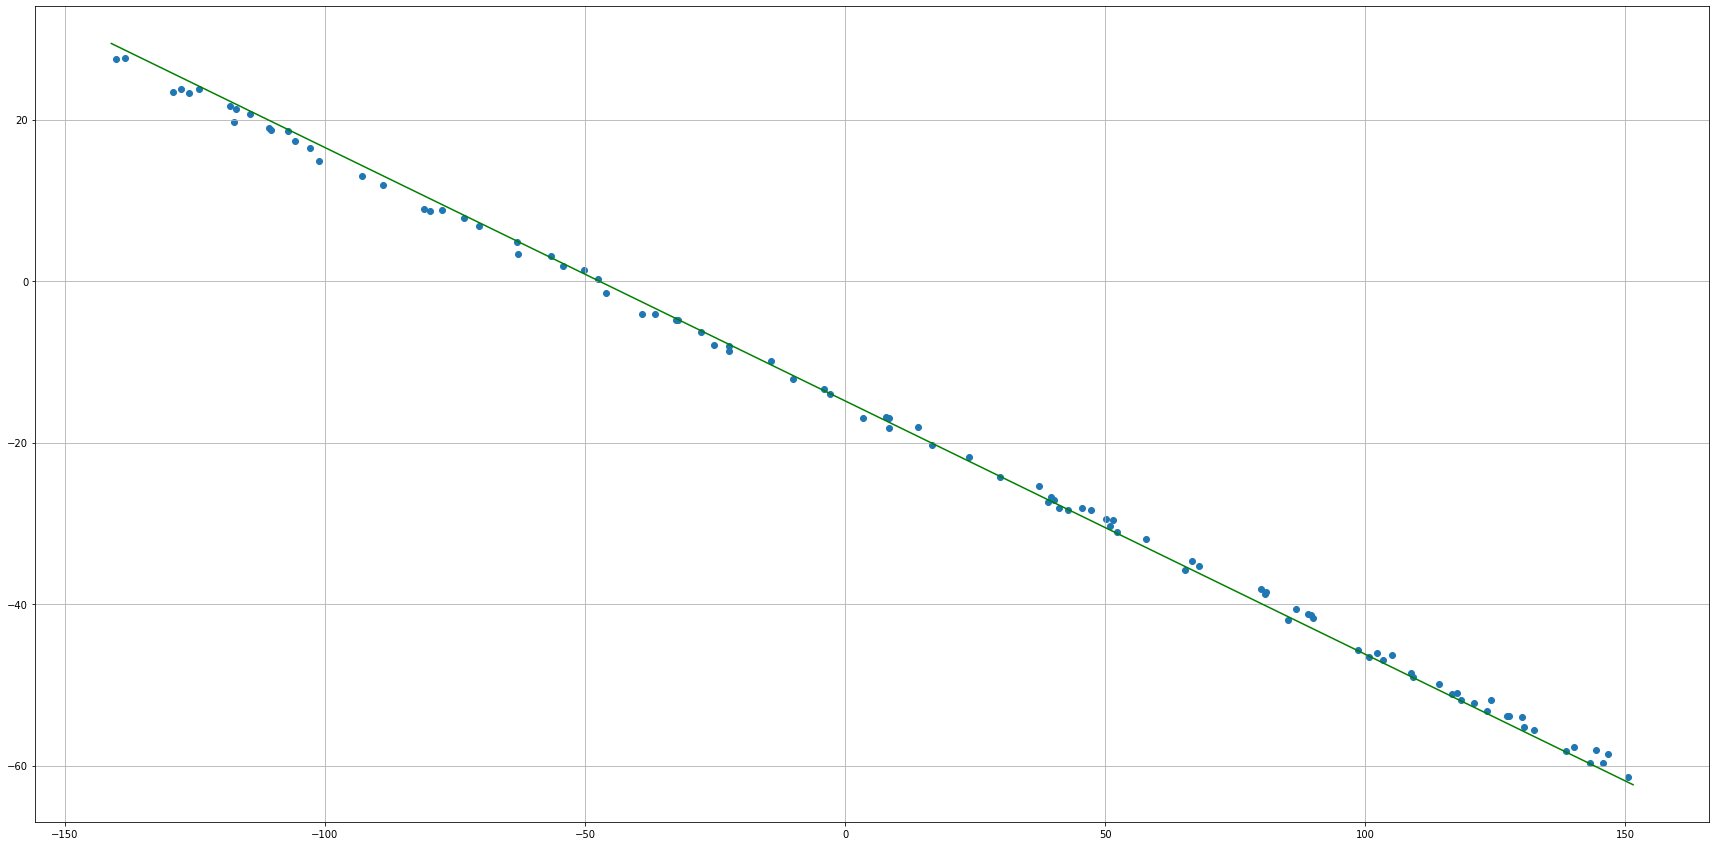

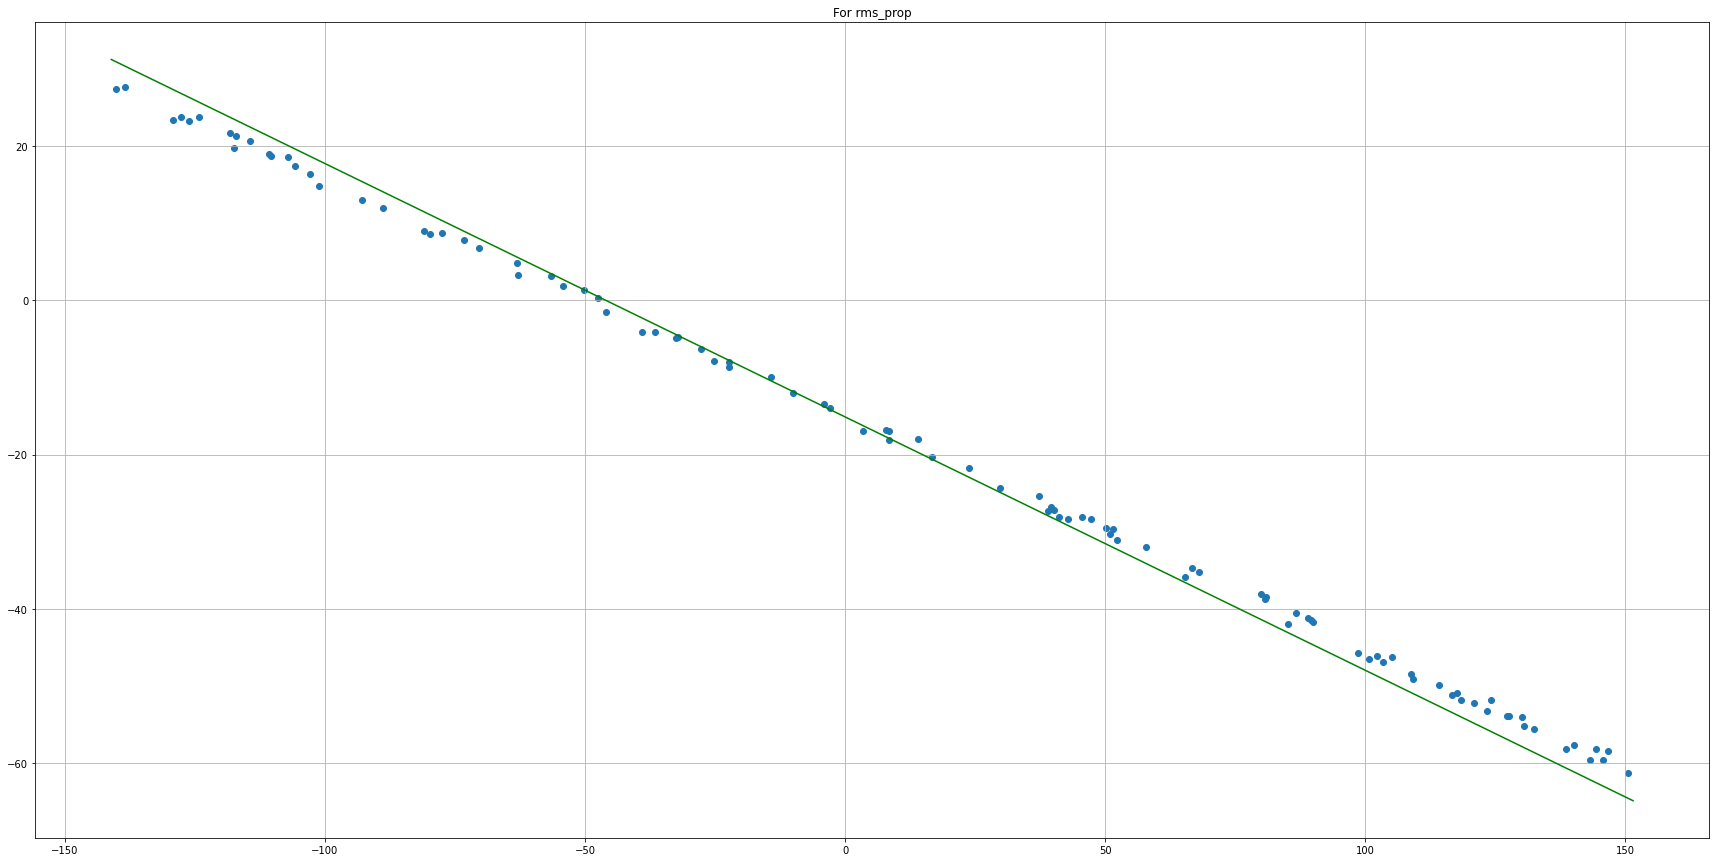

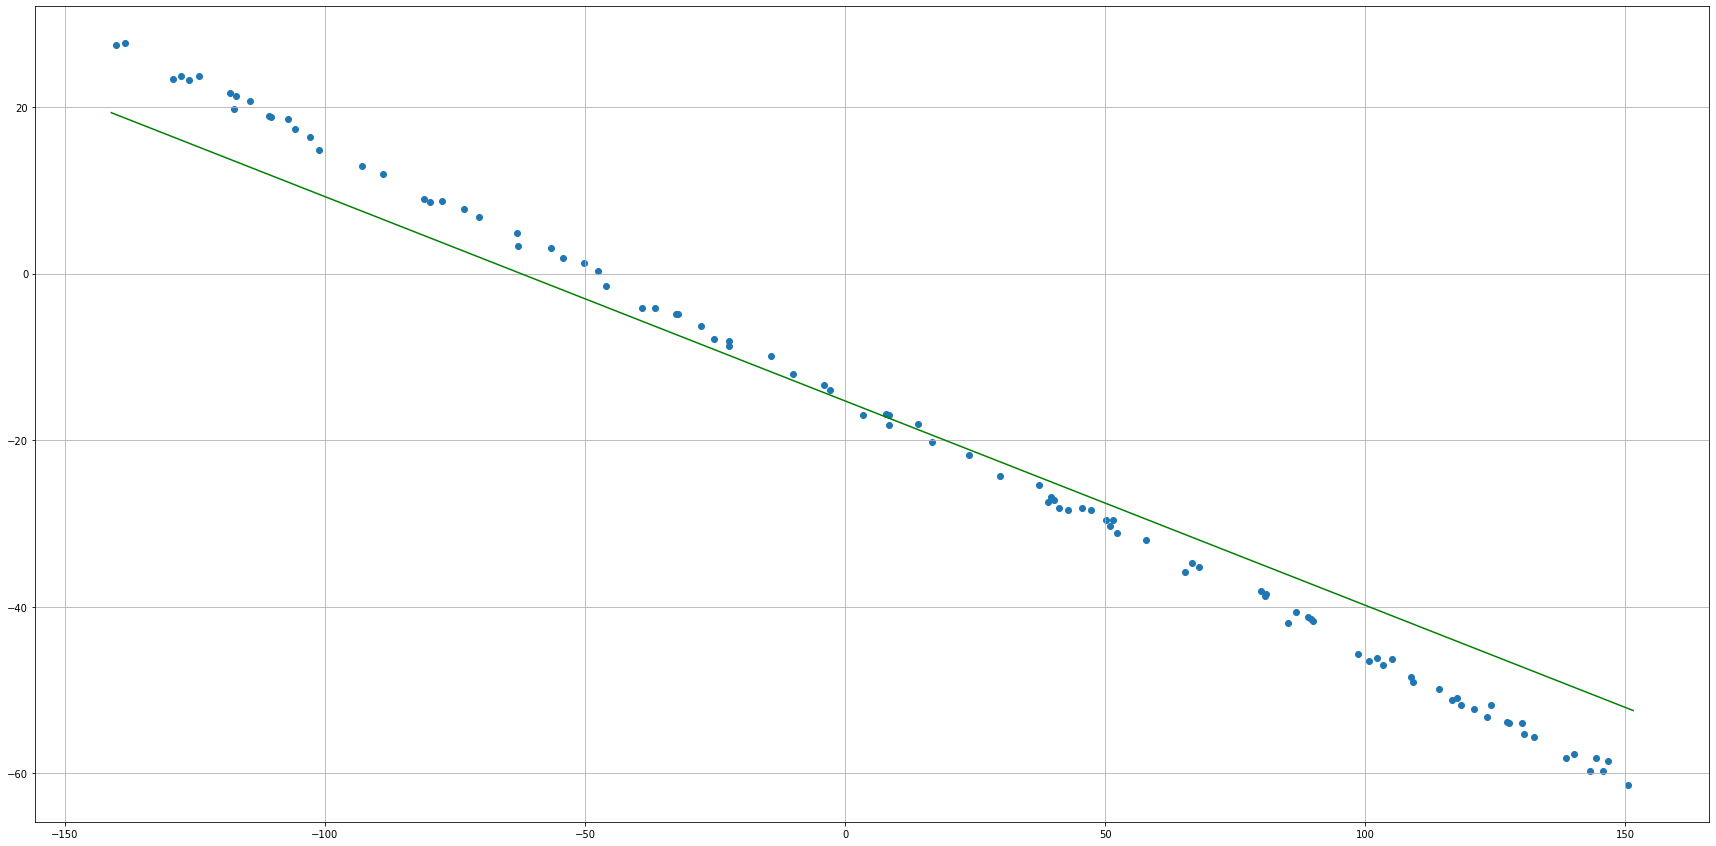

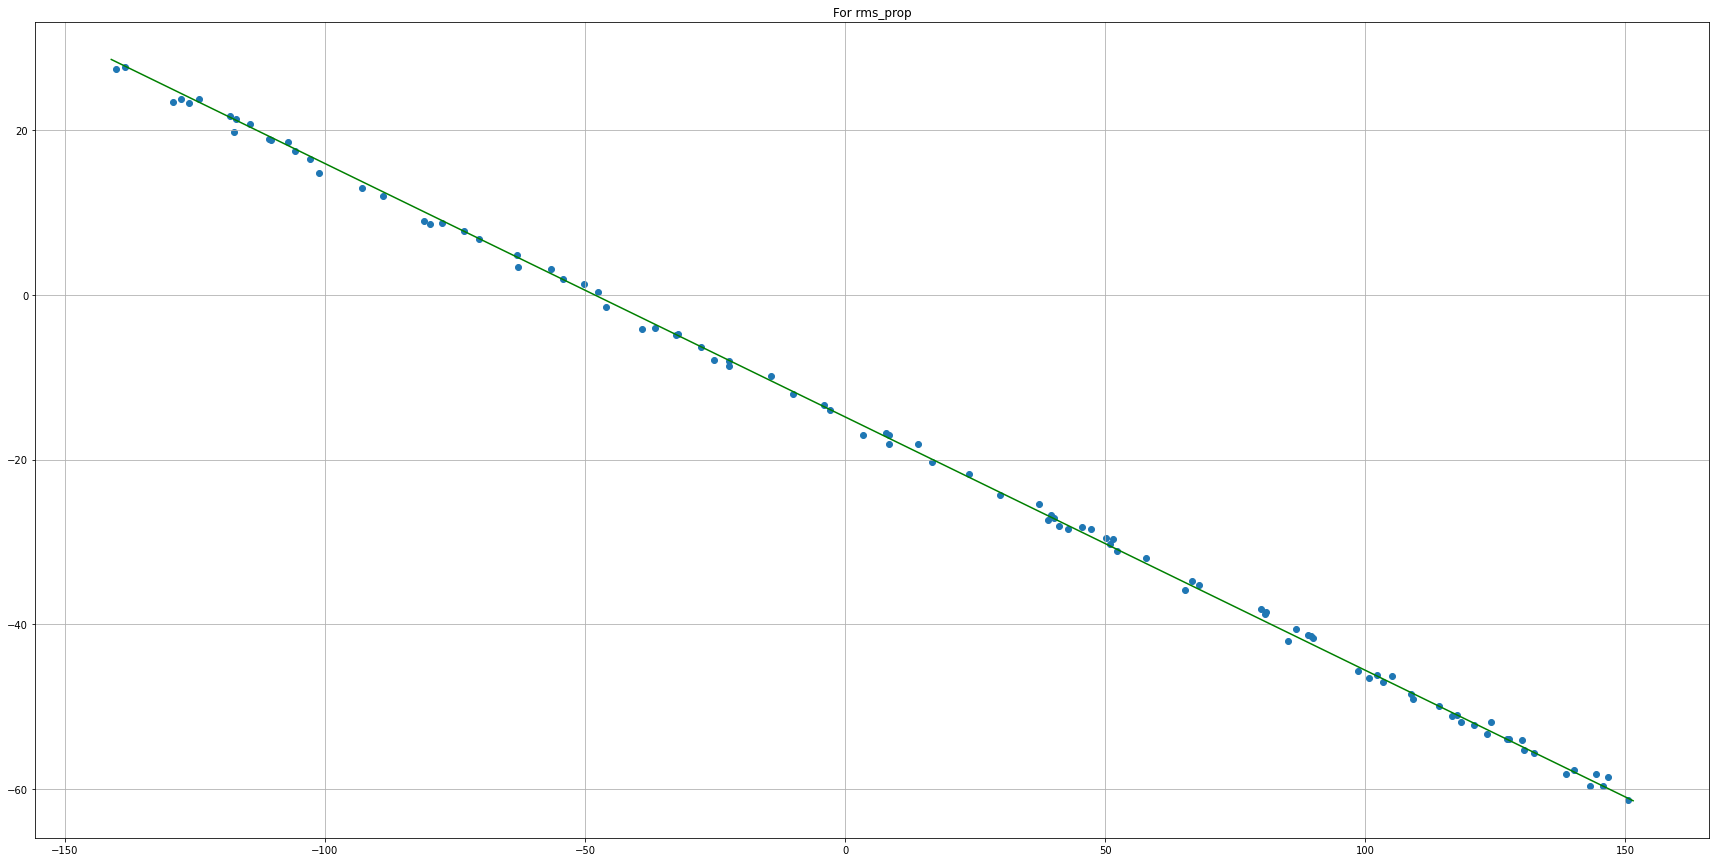

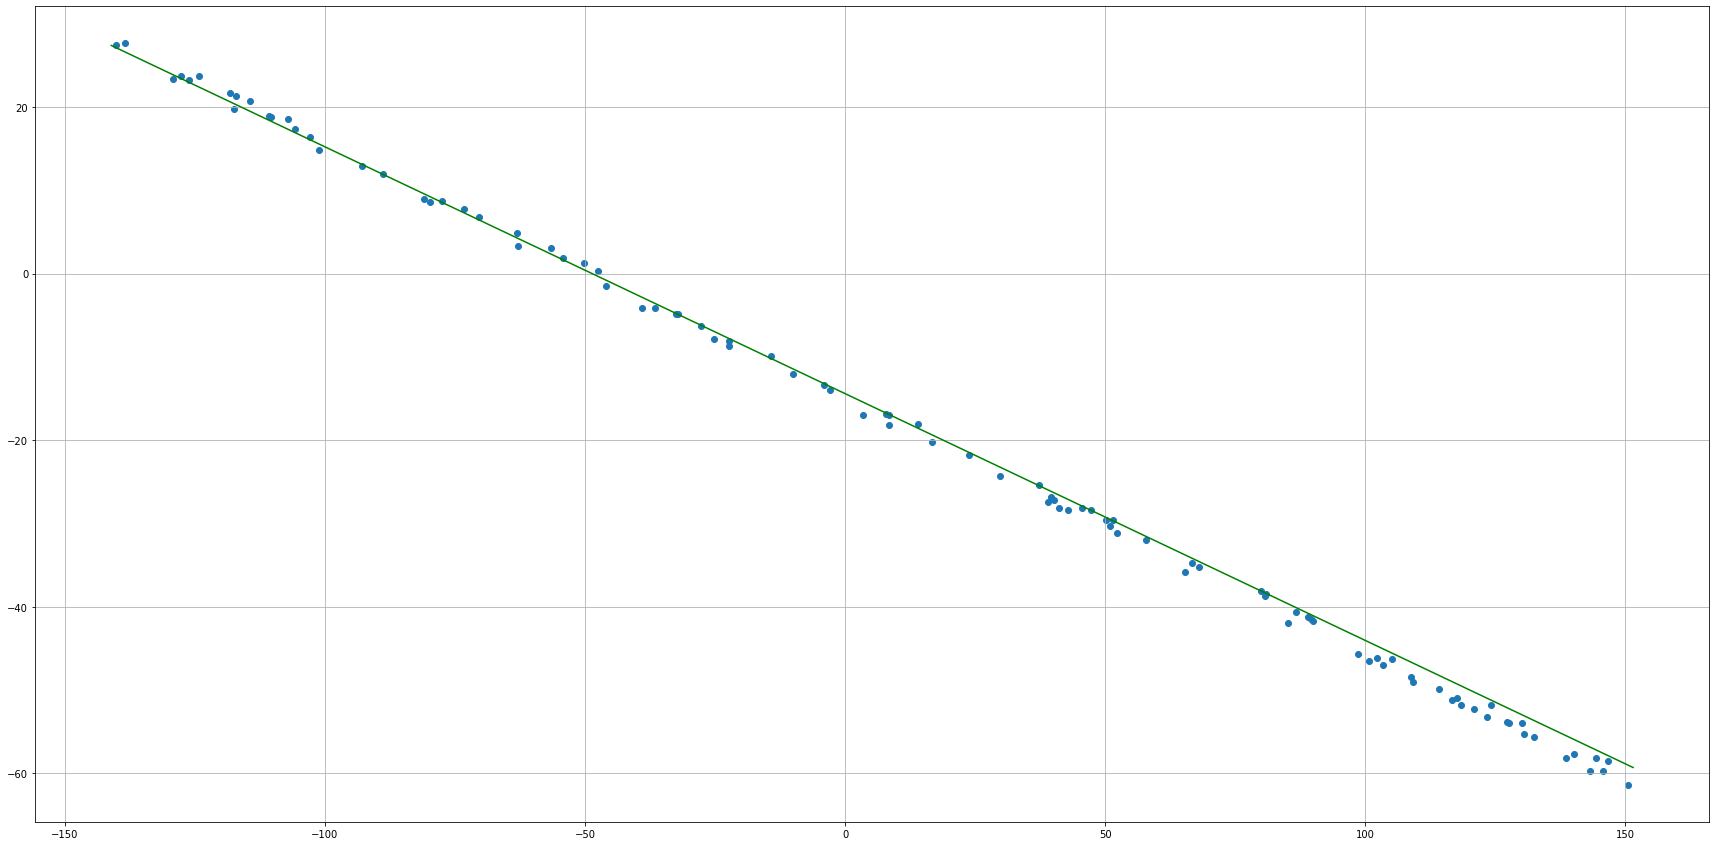

In [13]:
LR = 0.05

compare("ada_grad", sgd_ada_grad, {'lr0': 0.5, 'epoch': 1000}
        , torch.optim.Adagrad, {'lr': 0.5})
compare("rms_prop", sgd_rms_prop, {'lr0': LR, 'epoch': 1000, 'alpha': 0.5}
        , torch.optim.RMSprop, {'lr': LR, 'momentum': 0.5})
compare("rms_prop", sgd_adam, {'lr0': LR, 'epoch': 1000, 'alpha': 0.9, 'beta': 0.99}
        , torch.optim.Adam, {'lr': LR})